Total Number of Users (Tnu): 318
Total Numbers of Items (Tnu) 318
Task 5: Number of Ratings for Each Product:
Movie ID
Movie_1     190
Movie_10    194
Movie_2     194
Movie_3     204
Movie_4     211
Movie_5     198
Movie_6     212
Movie_7     208
Movie_8     185
Movie_9     203
Name: Rating, dtype: int64


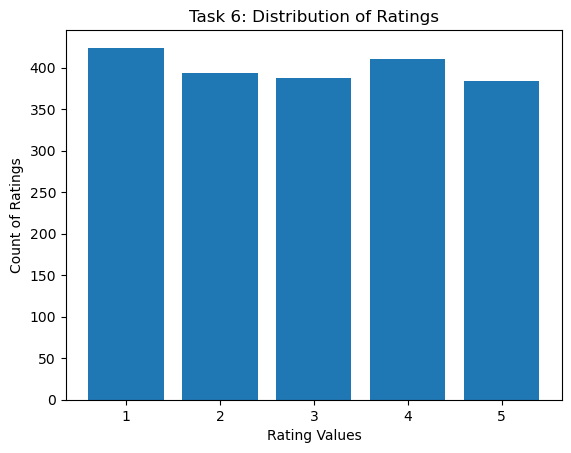

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd


file_path = 'C:/Users/user/Downloads/IRS Assignment 3-20241231T091819Z-001/IRS Assignment 3/221101345, Omar Hesham , Assignment 3 dataset.csv'
dataset = pd.read_csv(file_path)


Tnu = dataset['User ID'].nunique()
print("Total Number of Users (Tnu):", Tnu)
Tni = dataset['Movie ID'].nunique()
print("Total Numbers of Items (Tnu)", Tnu)

ratings_per_product = dataset.groupby('Movie ID')['Rating'].count()
print("Task 5: Number of Ratings for Each Product:")
print(ratings_per_product)

rating_distribution = dataset['Rating'].value_counts().sort_index()
plt.bar(rating_distribution.index, rating_distribution.values)
plt.title('Task 6: Distribution of Ratings')
plt.xlabel('Rating Values')
plt.ylabel('Count of Ratings')
plt.show()

In [20]:
#sparsity
total_possible_ratings = Tnu * Tni
total_actual_ratings = dataset['Rating'].count()
sparsity = 1 - (total_actual_ratings / total_possible_ratings)
print("Task 6: Sparsity of Matrix:", sparsity)

#average
average_ratings_per_product = ratings_per_product.mean()
bias_level = ratings_per_product.std()
print("Task 6: Average Ratings Per Product:", average_ratings_per_product)
print("Task 6: Bias Level (STD of Ratings):", bias_level)

#Lowest Rated 
lowest_rated_items = ratings_per_product.nsmallest(2)
I1, I2 = lowest_rated_items.index.tolist()
I1_count, I2_count = lowest_rated_items.values

print(f"Task 7: Target Items (Fewest Ratings): I1 = {I1} (Ratings = {I1_count}), I2 = {I2} (Ratings = {I2_count})")


Task 6: Sparsity of Matrix: 0.3713836477987421
Task 6: Average Ratings Per Product: 199.9
Task 6: Bias Level (STD of Ratings): 9.158481193832184
Task 7: Target Items (Fewest Ratings): I1 = Movie_8 (Ratings = 185), I2 = Movie_1 (Ratings = 190)


# Part 1

In [ ]:
I1_mean_rating = dataset.loc[dataset['Movie ID'] == I1, 'Rating'].mean()
I2_mean_rating = dataset.loc[dataset['Movie ID'] == I2, 'Rating'].mean()

print(f"3.2.1: Average Rating of Target Items:")
print(f"I1 ({I1}): {I1_mean_rating}")
print(f"I2 ({I2}): {I2_mean_rating}")

dataset.loc[(dataset['Movie ID'] == I1) & (dataset['Rating'].isna()), 'Rating'] = I1_mean_rating
dataset.loc[(dataset['Movie ID'] == I2) & (dataset['Rating'].isna()), 'Rating'] = I2_mean_rating

item_mean_ratings = dataset.groupby('Movie ID')['Rating'].mean()
print("Average rating for each item:")
print(item_mean_ratings)

dataset['Mean Rating'] = dataset['Movie ID'].map(item_mean_ratings)  
dataset['Rating Difference'] = dataset['Rating'] - dataset['Mean Rating']  

print("the Rating Difference:")
print(dataset[['Movie ID', 'Rating', 'Mean Rating', 'Rating Difference']].head(20))


rating_diff_pivot = dataset.pivot_table(index='User ID', columns='Movie ID', values='Rating Difference')

covariance_matrix = rating_diff_pivot.cov()

covariance_matrix = covariance_matrix.dropna(how='all', axis=0).dropna(how='all', axis=1)

print("Covariance matrix:")
print(covariance_matrix)

In [ ]:
covariance_matrix = rating_diff_pivot.cov()
def find_top_peers(item_id, matrix, top_n=5):
    
    if item_id not in matrix.columns:
        print(f"Item {item_id} not found in the matrix. Returning empty result.")
        return pd.Series(dtype=float)
    
    top_peers = matrix[item_id].drop(item_id, errors='ignore').sort_values(ascending=False).head(top_n)
    return top_peers

top_5_peers_I1 = find_top_peers(I1, covariance_matrix, top_n=5)
top_10_peers_I1 = find_top_peers(I1, covariance_matrix, top_n=10)
top_5_peers_I2 = find_top_peers(I2, covariance_matrix, top_n=5)
top_10_peers_I2 = find_top_peers(I2, covariance_matrix, top_n=10)

print("Top 5-peers for I1:\n", top_5_peers_I1)
print("Top 10-peers for I1:\n", top_10_peers_I1)
print("Top 5-peers for I2:\n", top_5_peers_I2)
print("Top 10-peers for I2:\n", top_10_peers_I2)
if top_5_peers_I1 is not None and not top_5_peers_I1.empty:
    peers_I1 = set(top_5_peers_I1.index)
else:
    peers_I1 = set()
if top_5_peers_I2 is not None and not top_5_peers_I2.empty:
    peers_I2 = set(top_5_peers_I2.index)
else:
    peers_I2 = set()
top_5_combined = peers_I1.union(peers_I2)
if I1 in rating_diff_pivot.columns:
    top_5_combined.add(I1)
if I2 in rating_diff_pivot.columns:
    top_5_combined.add(I2)
top_5_combined_list = list(top_5_combined)
if not top_5_combined_list:
    print("\nNo valid peers or target items found. Cannot create reduced dimensional space.")
else:
    
    mean_filled_pivot = rating_diff_pivot.fillna(rating_diff_pivot.mean())
    reduced_pivot = mean_filled_pivot[top_5_combined_list]
    threshold = 1e-6  
    reduced_pivot = reduced_pivot.applymap(lambda x: 0 if abs(x) < threshold else x)

    print("\n3.2.8: Reduced Dimensional Space for Each User (Top 5-Peers):")
    print(reduced_pivot)



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity  
def predict_missing_ratings(target_item, top_peers, reduced_pivot, sim_matrix):
    predictions = {}
    for user in reduced_pivot.index:  
        if pd.isna(reduced_pivot.loc[user, target_item]):  
            peer_ratings = reduced_pivot.loc[user, top_peers]  
            similarities = sim_matrix.loc[target_item, top_peers]  

            
            numerator = (peer_ratings * similarities).sum()
            denominator = similarities.sum()
            predictions[user] = numerator / denominator if denominator != 0 else None
        else:
            predictions[user] = reduced_pivot.loc[user, target_item]  
    return predictions

cosine_sim_matrix = cosine_similarity(rating_diff_pivot.fillna(0).T)  
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=rating_diff_pivot.columns, columns=rating_diff_pivot.columns)

valid_top_5_combined_list = [col for col in top_5_combined_list if col in rating_diff_pivot.columns]

predictions_I1_top_5 = predict_missing_ratings(I1, valid_top_5_combined_list, rating_diff_pivot, cosine_sim_df)

print("\n3.2.9: Predictions for Missing Ratings Using Top 5-Peers (I1):")
for user, prediction in predictions_I1_top_5.items():
    print(f"User: {user}, Predicted Rating for I1: {prediction}")


In [25]:
predictions_I2_top_5 = predict_missing_ratings(I2, valid_top_5_combined_list, rating_diff_pivot, cosine_sim_df)

def predict_missing_ratings_top_10(target_item, top_peers, reduced_pivot, sim_matrix):
    predictions = {}
    for user in reduced_pivot.index:  
        if pd.isna(reduced_pivot.loc[user, target_item]):  
            peer_ratings = reduced_pivot.loc[user, top_peers]  
            similarities = sim_matrix.loc[target_item, top_peers]  

            numerator = (peer_ratings * similarities).sum()
            denominator = similarities.sum()
            predictions[user] = numerator / denominator if denominator != 0 else None
        else:
            predictions[user] = reduced_pivot.loc[user, target_item]  
    return predictions

predictions_I1_top_10 = predict_missing_ratings_top_10(I1, top_10_combined_list, reduced_pivot_top_10_filled, cosine_sim_df)
predictions_I2_top_10 = predict_missing_ratings_top_10(I2, top_10_combined_list, reduced_pivot_top_10_filled, cosine_sim_df)

comparison = pd.DataFrame({
    "Top 5 Predictions (I1)": predictions_I1_top_5,
    "Top 10 Predictions (I1)": predictions_I1_top_10,
    "Top 5 Predictions (I2)": predictions_I2_top_5,
    "Top 10 Predictions (I2)": predictions_I2_top_10
})

print("\n3.2.12: Comparison of Predictions (Top 5 vs Top 10 Peers):")
print(comparison)



3.2.12: Comparison of Predictions (Top 5 vs Top 10 Peers):
          Top 5 Predictions (I1)  Top 10 Predictions (I1)  \
User_1                  0.994595                      3.0   
User_10                 0.007164                      0.0   
User_100               -0.005405                      3.0   
User_101               -0.005405                      4.0   
User_102               -0.055571                      1.0   
...                          ...                      ...   
User_95                -1.005405                      1.0   
User_96                -1.005405                      5.0   
User_97                -0.012559                      3.0   
User_98                -0.124669                      5.0   
User_99                -0.005405                      0.0   

          Top 5 Predictions (I2)  Top 10 Predictions (I2)  
User_1                       5.0                      5.0  
User_10                      4.0                      4.0  
User_100                   